In [73]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import numpy as np
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [74]:



api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
# tags = ['2024-03-17-00-55-52', '2024-03-17-10-41-24','2024-03-17-20-00-08']
# filters = {"tags": {"$in": tags}}
filters = {"config.env_description": "CliffWalking-v0", "state": "finished", "summary_metrics.Evaluation/Return": {"$exists": True}}
runs = api.runs(entity + "/" + project, filters=filters)
len(runs)

3

In [75]:

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)


df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

# filter out runs where "Evaluation/Return" is NaN

df

100%|██████████| 3/3 [00:00<00:00, 15787.84it/s]


,environment_steps,Self_Play/Returns,_timestamp,Self_Play/Mean_Entropy,Self_Play/Min_Timesteps,Self_Play/Total_Timesteps,policy_network,Evaluation/Timesteps,Training/Regularization_loss,Training/Value_and_Policy_loss,...,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform,policy_combination
0,6935,"{'_type': 'histogram', 'bins': [-17, -16.9375,...",1.710942e+09,0.185708,13,86,{'sha256': '384c8c50c39ee9fabce38cc3422cd1b0fd...,13,160.558090,0.645144,...,1,identity,default,0.0001,PolicyPUCT,6,mvc,10,identity,mvc+PolicyPUCT
1,8461,"{'_type': 'histogram', 'bins': [-23, -22.89062...",1.710942e+09,0.366594,16,113,"{'height': 480, 'sha256': '515b39300b9d986dde1...",15,167.377121,0.457597,...,1,identity,default,0.0001,PUCT,6,mvc,10,identity,mvc+PUCT
2,9714,"{'_type': 'histogram', 'bins': [-142, -140.125...",1.710941e+09,0.692462,22,193,"{'width': 640, 'format': 'png', 'height': 480,...",17,173.282028,55.605449,...,1,identity,default,0.0001,PUCT,6,visit,10,identity,visit+PUCT


In [76]:
df.columns

Index(['environment_steps', 'Self_Play/Returns', '_timestamp',
       'Self_Play/Mean_Entropy', 'Self_Play/Min_Timesteps',
       'Self_Play/Total_Timesteps', 'policy_network', 'Evaluation/Timesteps',
       'Training/Regularization_loss', 'Training/Value_and_Policy_loss',
       '_step', 'episodes', 'Self_Play/Mean_Discounted_Return',
       'Self_Play/Entropies', 'visit_counts', '_runtime',
       'Evaluation/Mean_Entropy', 'Self_Play/Mean_Timesteps', 'grad_steps',
       'Self_Play/Mean_Return', 'Self_Play/Timesteps', 'Self_Play/Max_Return',
       'Training/Learning_Rate', 'Evaluation/Return',
       'Self_Play/Total_Mean_Discounted_Return', 'Training/Policy_loss',
       'Self_Play/Discounted_Return', 'Training/Replay_Buffer_Size',
       'Evaluation/Discounted_Return', 'Training/Value_loss',
       'Self_Play/Min_Return', '_wandb', 'value_network',
       'Training/Value_Simularities', 'Self_Play/EMA_Discounted_Return',
       'ncols', 'layers', 'puct_c', 'workers', 'lr_gamma', '

In [77]:
tasks_col = "env_description"
alg_col = "policy_combination"


algorithms = df[alg_col].unique()
num_tasks = len(df[tasks_col].unique())
num_runs = len(df) / (num_tasks * len(algorithms))


assert num_runs.is_integer()
num_runs = int(num_runs)
print(f"Number of tasks: {num_tasks}")
print(f"Number of runs: {num_runs}")
print(f"Number of algorithms: {len(algorithms)}")

Number of tasks: 1
Number of runs: 1
Number of algorithms: 3


In [78]:

min_scores = {
    "CliffWalking-v0": -200,
}
max_scores = {
    "CliffWalking-v0": -13,
}

target_col = "Evaluation/Return"

columns_to_normalize = [target_col]

for column in columns_to_normalize:
  col_name= column + "_normalized"
  for task in df[tasks_col].unique():
    task_max = max_scores[task]
    task_min = min_scores[task]
    df.loc[df[tasks_col] == task, col_name] = (df[column] - task_min) / (task_max - task_min)

df["Evaluation/Return_normalized"]


0    1.000000
1    0.989305
2    0.978610
Name: Evaluation/Return_normalized, dtype: float64

In [79]:
from typing import List, Mapping, Union

# check that the number of runs is an integer
"""
score_dict: A dictionary of scores for each method where scores are arranged
      as a matrix of the shape (`num_runs` x `num_tasks` x ..). For example, the
      scores could be 2D matrix containing final scores of the algorithm or a 3D
      matrix containing evaluation scores at multiple points during training.
"""
score_dict = {}
for alg in algorithms:
    scores = df[df[alg_col] == alg][target_col+"_normalized"]
    scores = scores.values.reshape((int(num_runs), num_tasks))
    score_dict[alg] = scores
score_dict

{'mvc+PolicyPUCT': array([[1.]]),
 'mvc+PUCT': array([[0.98930481]]),
 'visit+PUCT': array([[0.97860963]])}

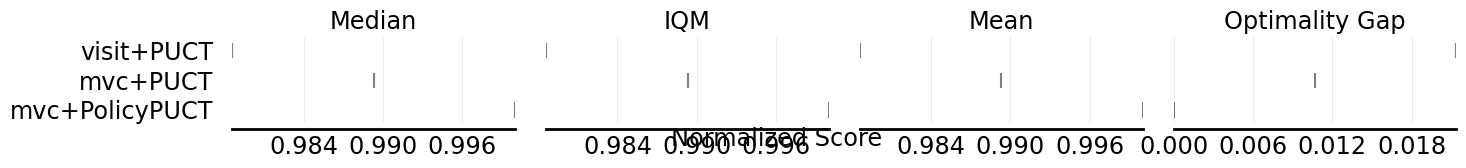

In [80]:
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  metrics.aggregate_optimality_gap(x)])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  score_dict, aggregate_func, reps=5000)
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean', 'Optimality Gap'],
  algorithms=algorithms)


In [81]:
aggregate_score_cis


{'mvc+PolicyPUCT': array([[1., 1., 1., 0.],
        [1., 1., 1., 0.]]),
 'mvc+PUCT': array([[0.98930481, 0.98930481, 0.98930481, 0.01069519],
        [0.98930481, 0.98930481, 0.98930481, 0.01069519]]),
 'visit+PUCT': array([[0.97860963, 0.97860963, 0.97860963, 0.02139037],
        [0.97860963, 0.97860963, 0.97860963, 0.02139037]])}

In [82]:
data = []
for run in tqdm(runs):
    history: pd.DataFrame = run.history()
    for i, row in history.iterrows():
        # add a row to the data with run.config and the history row merged
        data.append({**run.config, **row})

history_df = pd.DataFrame(data)
history_df

100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


,ncols,layers,puct_c,workers,lr_gamma,dir_alpha,env_params,eval_param,hidden_dim,iterations,...,Evaluation/Discounted_Return,Self_Play/Max_Return,grad_steps,Self_Play/Returns,value_network,Self_Play/Min_Return,Training/Replay_Buffer_Size,Training/Value_loss,episodes,policy_network
0,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,-100.0,-100.0,0.0,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...","{'size': 37626, 'height': 480, 'width': 640, '...",-100.0,6.0,0.990673,6.0,"{'format': 'png', 'path': 'media/images/policy..."
1,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,NaN,-56.0,8.0,"{'_type': 'histogram', 'values': [5, 0, 0, 0, ...","{'format': 'png', 'path': 'media/images/value_...",-100.0,12.0,0.987845,12.0,"{'format': 'png', 'path': 'media/images/policy..."
2,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,NaN,-100.0,16.0,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...","{'size': 39491, 'height': 480, 'width': 640, '...",-100.0,18.0,0.989823,18.0,"{'height': 480, 'width': 640, '_type': 'image-..."
3,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,NaN,-80.0,24.0,"{'_type': 'histogram', 'values': [4, 0, 0, 0, ...","{'format': 'png', 'path': 'media/images/value_...",-100.0,24.0,0.985696,24.0,"{'_type': 'image-file', 'format': 'png', 'path..."
4,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,NaN,-100.0,32.0,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...","{'format': 'png', 'path': 'media/images/value_...",-100.0,30.0,0.987822,30.0,"{'_type': 'image-file', 'format': 'png', 'path..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,NaN,-21.0,208.0,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'size': 38244, 'height': 480, 'width': 640, '...",-61.0,60.0,6.979451,162.0,{'sha256': '87295a5ac7fb31db39acb5c4c239c1c622...
89,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,NaN,-15.0,216.0,"{'packedBins': {'min': -34, 'size': 0.296875, ...",{'path': 'media/images/value_network_27_5218bc...,-34.0,60.0,7.740192,168.0,"{'size': 53455, 'height': 480, 'width': 640, '..."
90,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,NaN,-22.0,224.0,"{'packedBins': {'min': -53, 'size': 0.484375, ...","{'format': 'png', 'path': 'media/images/value_...",-53.0,60.0,5.943950,174.0,{'sha256': 'cc582d1ea1566058741362de61fcdc1463...
91,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,NaN,-22.0,232.0,"{'packedBins': {'count': 64, 'min': -142, 'siz...",{'sha256': 'bd59495ad6094568a6606ba65d0d636b58...,-142.0,60.0,79.077741,180.0,"{'_type': 'image-file', 'format': 'png', 'path..."


In [83]:
df.columns

Index(['environment_steps', 'Self_Play/Returns', '_timestamp',
       'Self_Play/Mean_Entropy', 'Self_Play/Min_Timesteps',
       'Self_Play/Total_Timesteps', 'policy_network', 'Evaluation/Timesteps',
       'Training/Regularization_loss', 'Training/Value_and_Policy_loss',
       '_step', 'episodes', 'Self_Play/Mean_Discounted_Return',
       'Self_Play/Entropies', 'visit_counts', '_runtime',
       'Evaluation/Mean_Entropy', 'Self_Play/Mean_Timesteps', 'grad_steps',
       'Self_Play/Mean_Return', 'Self_Play/Timesteps', 'Self_Play/Max_Return',
       'Training/Learning_Rate', 'Evaluation/Return',
       'Self_Play/Total_Mean_Discounted_Return', 'Training/Policy_loss',
       'Self_Play/Discounted_Return', 'Training/Replay_Buffer_Size',
       'Evaluation/Discounted_Return', 'Training/Value_loss',
       'Self_Play/Min_Return', '_wandb', 'value_network',
       'Training/Value_Simularities', 'Self_Play/EMA_Discounted_Return',
       'ncols', 'layers', 'puct_c', 'workers', 'lr_gamma', '

In [94]:
x_col = "episodes"
# filter out rows with non nan eval
filtered_history_df = history_df[history_df[target_col].notna()]
x_col_values = filtered_history_df[filtered_history_df["episodes"].isna()]
x_col_values

,ncols,layers,puct_c,workers,lr_gamma,dir_alpha,env_params,eval_param,hidden_dim,iterations,...,Evaluation/Discounted_Return,Self_Play/Max_Return,grad_steps,Self_Play/Returns,value_network,Self_Play/Min_Return,Training/Replay_Buffer_Size,Training/Value_loss,episodes,policy_network
30,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,-13.0,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None
61,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,-15.0,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None
92,12,5,1,6,1,2,"{'id': 'CliffWalking-v0', 'max_episode_steps':...",1,64,30,...,-17.0,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None


In [ ]:
plot_utils.plot_sample_efficiency_curve(
    timesteps, iqm_scores, iqm_cis, algorithms=algorithms,
    xlabel=r'Number of Frames (in millions)',
    ylabel='IQM Human Normalized Score')